In [2]:
from read_data import read_data, train_test, user_item_matrix
from svd import Recommender, MostPopularRecommender, filter_new, convert_to_recsys_data
import numpy as np
import seaborn as sns
from pandas.tseries.offsets import *
%matplotlib inline

/home/akis/.local/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


Разбиваем отсортированный по времени датафрейм на тест и трейн (доля test_size с конца).
test_size - время, попадающее в тестовый набор (с конца)
sales_end_offset - считаются активными все сеты, имеющие хотя бы одну продажу за время test_start-offset
Из всего датафрейма выкидываются записи, относящиеся к другим сетам.

In [2]:
train, test = train_test(read_data("../../input/"), test_size=DateOffset(months=0, days=5),  sales_end_offset=DateOffset(months=0, days=10))

Active sets: 45
Test size: 229 Train size 6023


Удаляем из тестового датасета пользователей, не встречающихся в тренировочном

In [3]:
test = filter_new(train, test)

Конвертируем датафреймы в формат, понимаемый recsys. Tuple вида (rating, user, item)

In [4]:
train = convert_to_recsys_data(train)
test = convert_to_recsys_data(test)

Заводим обертку вокруг рекомендатора (заведена с заделом под расширение и дополнительные параметры)

In [5]:
rec = Recommender(train, k=50)

Метод evaluate принимает тестовый сет и возвращает MAP по нему.

In [6]:
acc = rec.evaluate(test)
print acc

0.101004394225


Точность рекомендатора, выдающего 10 самых популярных сетов:

In [7]:
most_pop_rec = MostPopularRecommender(train)
most_pop_acc = most_pop_rec.evaluate(test)
print most_pop_acc

0.0427024482109


Построим график MAP от k (число измерений в SVD), красная линия - точность MostPopularRecommender

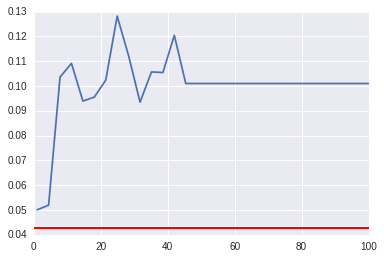

In [8]:
maps = []
ks = np.linspace(1, 100, 30)
for k in ks:
    rec = Recommender(train, k=k)
    maps.append(rec.evaluate(test))

sns.plt.plot([0, 100], [most_pop_acc, most_pop_acc], color='r', linestyle='-', linewidth=2)
sns.plt.plot(ks, maps)

Построим график зависимости MAP от sales_end_offset

Active sets: 21
Test size: 354 Train size 4573
Active sets: 45
Test size: 403 Train size 5903
Active sets: 47
Test size: 403 Train size 6024
Active sets: 56
Test size: 403 Train size 6958
Active sets: 62
Test size: 403 Train size 7889
Active sets: 67
Test size: 403 Train size 8177
Active sets: 72
Test size: 403 Train size 8374
Active sets: 81
Test size: 403 Train size 9081
Active sets: 92
Test size: 408 Train size 9752
Active sets: 97
Test size: 408 Train size 11114
Active sets: 107
Test size: 408 Train size 11524
Active sets: 118
Test size: 408 Train size 12145
Active sets: 128
Test size: 408 Train size 12971
Active sets: 131
Test size: 408 Train size 13231
Active sets: 132
Test size: 408 Train size 13325


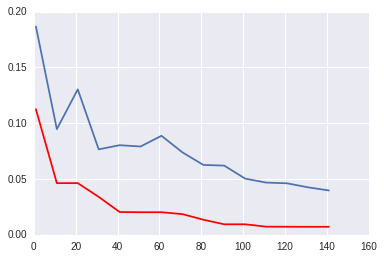

In [10]:
offsets = range(1, 150, 10)
svd_maps = []
pop_maps = []
for off in offsets:
    train, test = train_test(read_data("../../input/"), test_size=DateOffset(months=0, days=10),  sales_end_offset=DateOffset(months=0, days=off))
    test = filter_new(train, test)
    train = convert_to_recsys_data(train)
    test = convert_to_recsys_data(test)
    rec = Recommender(train, k=50)
    svd_maps.append(rec.evaluate(test))
    most_pop_rec = MostPopularRecommender(train)
    most_pop_acc = most_pop_rec.evaluate(test)
    pop_maps.append(most_pop_acc)
sns.plt.plot(offsets, svd_maps)
sns.plt.plot(offsets, pop_maps, color="r")
sns.plt.show()

Точность понижается с увеличением датасета. 

Сгенерируем .csv формата user_id, set_id, rating. 

In [5]:
# train, test dataframes, splitted py test_size offset
train, test = train_test(read_data("../../input/"), test_size=DateOffset(months=1, days=0),  sales_end_offset=DateOffset(months=0, days=20))
test_user_ids = test["user_id"].unique()
train_user_ids = train["user_id"].unique()
# convert dataframes to recsys format
train = convert_to_recsys_data(train)
test = convert_to_recsys_data(test)
# instantiate the recommender with (possibly) optimal number of svd dimensions
svd_rec = Recommender(train, k=46)
pop_rec = MostPopularRecommender(train)
svd_recs = []
most_pop_recs = []

for test_id in test_user_ids:
    if test_id in train_user_ids:
        svd_recs.extend(svd_rec.recommend(test_id))
    else:
        most_pop_recs.extend(pop_rec.recommend(test_id))

        
import csv
with open('svd_recs.csv', 'wb') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    writer.writerow(["user_id", "set_id", "rating"])
    for recommendation in svd_recs:
        writer.writerow(recommendation)
        
with open('most_pop_recs.csv', 'wb') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    writer.writerow(["user_id", "set_id"])
    for recommendation in most_pop_recs:
        writer.writerow(recommendation)


Active sets: 47
Test size: 855 Train size 7015
